In [19]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize

In [20]:
# Data 
file_path = "目标文件-增加气象数据.csv"  
load_data = pd.read_csv(file_path)
selected_columns = ['时间', '负荷', '日前电价', '温度']
df_selected = load_data[selected_columns]
df_selected.rename(columns={'时间': 'Time', '负荷': 'Load', '日前电价': 'DayAheadPrice', '温度': 'temperature'}, inplace=True)
load_week = df_selected.iloc[:672]

# SDP beta = 0.9

In [21]:
T = len(load_week)  # Number of time steps (1 week)
p = load_week["DayAheadPrice"].values
demand = load_week["Load"].values * 0.01

SOC_max = 800.0  # Maximum battery capacity (MWh)
SOC_step = 10    # Step size for discretizing SOC
S_space = np.arange(0, SOC_max + SOC_step, SOC_step)  # Discrete SOC states

eff_c = 0.95  # Charging efficiency
eff_d = 0.95  # Discharging efficiency

# Control actions: from -50 MW (discharge) to +50 MW (charge)
U_max = 50.0
U_step = 5.0
U_space = np.arange(-U_max, U_max + U_step, U_step)

# Define error space and corresponding probabilities for the demand uncertainty
e_space = np.linspace(-50, 50, 25)
P_e = stats.norm.pdf(e_space, loc=0, scale=10)
P_e /= np.sum(P_e) 

# Scaling coefficient for load shifting penalty
beta = 0.9
# Discount factor
gamma = 0.95
# Average (reference) demand
D_bar = np.mean(demand)
# Average price
p_bar = np.mean(p)
# Convergence parameters
epsilon = 1e6
max_iterations = 5
# normalization coefficients
scale_C1 = np.max(np.abs((p - p_bar)[:, None] * U_space))  
scale_C2 = np.max((demand[:, None] + U_space - D_bar)**2)  

In [22]:
V = np.zeros((T+1, len(S_space)))  # Terminal cost = 0 at t = T
policy = np.zeros((T, len(S_space)))  # Store the optimal action at each (t, SOC)

# -----------------------------
# 4. Value Iteration Loop
# -----------------------------
converged = False
iteration = 0

while not converged and iteration < max_iterations:
    V_new = np.zeros_like(V)
    
    # Iterate backward in time: from T-1 down to 0
    for t in range(T - 1, -1, -1):
        pt = p[t]  # Price at time t
        
        # For each possible SOC state
        for si, soc in enumerate(S_space):
            best_cost = np.inf
            best_action = 0
            
            # Try each possible charge/discharge action
            for a in U_space:
                # Compute new SOC after applying action a
                if a >= 0:
                    # Charging: add eff_c * a
                    soc_new = soc + eff_c * a
                else:
                    # Discharging: subtract |a|/eff_d (note: a is negative)
                    soc_new = soc + (a / eff_d)
                
                # Enforce bounds: skip actions that yield an infeasible SOC
                if soc_new < 0 or soc_new > SOC_max:
                    continue
                
                # Determine the index of the new SOC in the discretized space
                new_si = int(round(soc_new / SOC_step))
                new_si = np.clip(new_si, 0, len(S_space)-1)  # Ensure valid indices
                
                exp_cost = 0.0
                # Loop over the error space to compute the expected cost
                for e, pe in zip(e_space, P_e):
                    D_t = demand[t] + e  # Adjusted demand at time t
                    # Immediate cost: battery operation cost + load shifting penalty
                    norm_C1 = ((pt - p_bar) * a) / scale_C1
                    norm_C2 = ((D_t + a - D_bar)**2) / scale_C2
                    cost_scenario = beta * norm_C1 + (1 - beta) * norm_C2
                    #cost_scenario = beta*(pt-p_bar) * a + (1-beta) * (D_t + a - D_bar)**2
                    # Add discounted future cost from the next state
                    cost_scenario += gamma * V[t+1, new_si]
                    exp_cost += pe * cost_scenario
                
                # Choose the action that minimizes the expected total cost
                if exp_cost < best_cost:
                    best_cost = exp_cost
                    best_action = a
            
            V_new[t, si] = best_cost
            policy[t, si] = best_action
    
    # Check for convergence
    delta = np.max(np.abs(V_new - V))
    if delta < epsilon * (1 - gamma) / (2 * gamma):
        converged = True
    
    V = V_new.copy()
    iteration += 1
    print(f"Iteration {iteration}: Max Change = {delta:.6f}")

print("Optimized Battery SDP completed. Optimal policy computed.")


Iteration 1: Max Change = 0.882615
Optimized Battery SDP completed. Optimal policy computed.


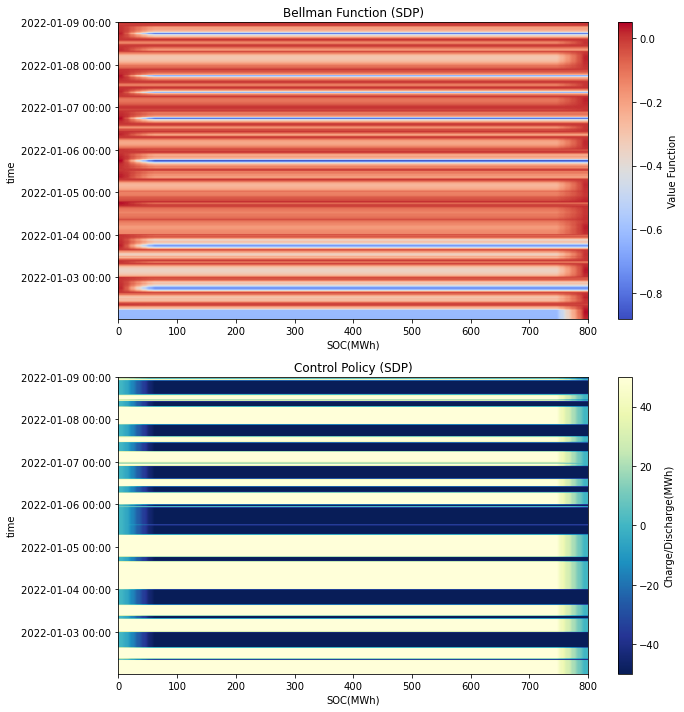

In [23]:
load_week['Time'] = pd.to_datetime(load_week['Time'])
time_index = load_week["Time"]  
time_nums = mdates.date2num(time_index)

# Use the first and last time values from your dataset
ymin, ymax = time_nums[0], time_nums[-1]
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Visualize first 12 rows of V
im1 = axs[0].imshow(V[:T, :], aspect='auto', cmap='coolwarm',
                    extent=[S_space.min(), S_space.max(), ymin, ymax], origin='lower')
axs[0].set_title("Bellman Function (SDP)")
axs[0].set_xlabel("SOC(MWh)")
axs[0].set_ylabel("time")
axs[0].yaxis_date()  # Tell matplotlib that the y-axis has dates
axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("Value Function")

im2 = axs[1].imshow(policy, aspect='auto', cmap='YlGnBu_r',
                    extent=[S_space.min(), S_space.max(), ymin, ymax], origin='lower')
axs[1].set_title("Control Policy (SDP)")
axs[1].set_xlabel("SOC(MWh)")
axs[1].set_ylabel("time")
axs[1].yaxis_date()  # Tell matplotlib that the y-axis has dates
axs[1].yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Charge/Discharge(MWh)")

plt.tight_layout()
plt.savefig('Beta0.9policy.png')
plt.show()

In [24]:
def simulate_policy(policy, S_space, U_space, eff_c, eff_d, T, init_soc_idx):
    """Simulate the battery's SOC over time using the computed policy."""
    soc_trajectory = np.zeros(T+1)
    soc_trajectory[0] = S_space[init_soc_idx]
    
    for t in range(T):
        # Find the chosen action from the policy
        si = np.argmin(np.abs(S_space - soc_trajectory[t]))  # index of nearest SOC in S_space
        action = policy[t, si]
        
        # Update SOC
        if action >= 0:
            soc_next = soc_trajectory[t] + eff_c * action
        else:
            soc_next = soc_trajectory[t] + (action / eff_d)
        
        # Clip to bounds, just to be safe:
        soc_next = max(0, min(soc_next, S_space[-1]))
        soc_trajectory[t+1] = soc_next
    
    return soc_trajectory

In [25]:
def simulate_net_load(policy, S_space, eff_c, eff_d, T, init_soc, demand):
   
    # Find the index in S_space closest to init_soc
    init_si = int(np.argmin(np.abs(S_space - init_soc)))
    
    net_load = np.zeros(T)
    soc_traj = np.zeros(T+1)
    soc_traj[0] = S_space[init_si]
    
    for t in range(T):
        
        # Find which SOC index we are currently at (round to nearest discretized level)
        si = np.argmin(np.abs(S_space - soc_traj[t]))
        
        # Get the optimal action at this time and state
        a = policy[t, si]
        
        # Compute the net load
        net_load[t] = demand[t] + a
        
        # Update SOC for next step
        if a >= 0:
            # Charging
            soc_next = soc_traj[t] + eff_c * a
        else:
            # Discharging
            soc_next = soc_traj[t] + (a / eff_d)  # a < 0 => negative
        
        # Clip to [0, SOC_max] just in case of rounding
        soc_next = max(0, min(soc_next, S_space[-1]))
        soc_traj[t+1] = soc_next
    
    return net_load, soc_traj

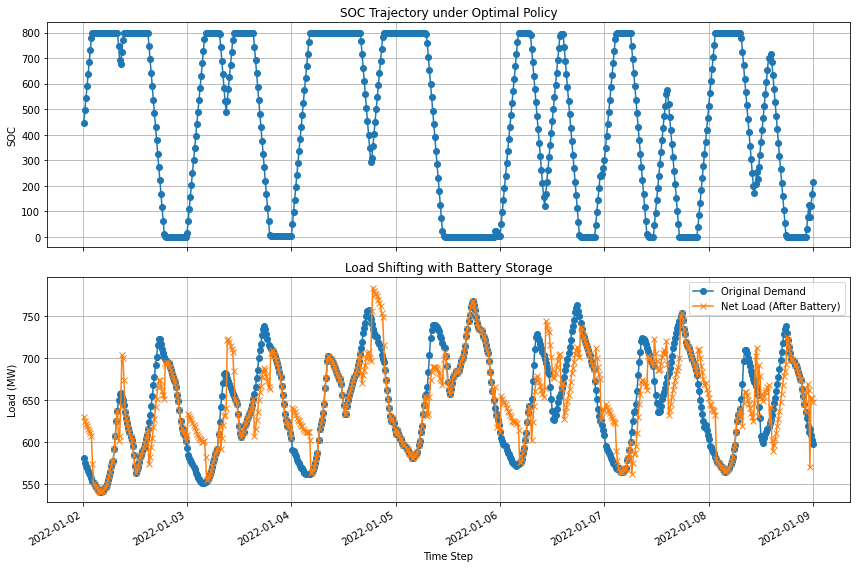

Total normalized cost (SDP): -54.61


In [26]:
time_axis = load_week["Time"].values
init_soc = 0.5 * SOC_max  # Start at 50% of battery capacity
init_soc_idx = np.argmin(np.abs(S_space - init_soc))
soc_traj = simulate_policy(policy, S_space, U_space, eff_c, eff_d, T, init_soc_idx)
net_load, soc_traj2 = simulate_net_load(policy, S_space, eff_c, eff_d, T, init_soc, demand)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First plot: SOC trajectory
axs[0].plot(time_axis, soc_traj[1:], marker='o')
axs[0].set_ylabel('SOC')
axs[0].set_title('SOC Trajectory under Optimal Policy')
axs[0].grid(True)

# Second plot: Load shifting
axs[1].plot(time_axis, demand, label="Original Demand", marker='o')
axs[1].plot(time_axis, net_load, label="Net Load (After Battery)", marker='x')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Load (MW)')
axs[1].set_title('Load Shifting with Battery Storage')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and rotate x-axis labels nicely
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Save the figure
plt.savefig('Beta0.9_SOC_and_LoadShift.png')
plt.show()

# Add after your simulation
soc = init_soc
total_cost_sdp = 0.0
for t in range(T):
    a = policy[t, int(round(soc / SOC_step))]

    # Apply action and update SOC
    if a >= 0:
        actual_charge = min(a, (SOC_max - soc) / eff_c)
        soc_new = soc + eff_c * actual_charge
    else:
        actual_discharge = max(a, -soc * eff_d)
        soc_new = soc + actual_discharge / eff_d
    soc_new = np.clip(soc_new, 0, SOC_max)

    # Compute normalized cost
    pt = p[t]
    D_t = demand[t]
    norm_op = ((pt - p_bar) * a) / scale_C1
    norm_shift = ((D_t + a - D_bar) ** 2) / scale_C2
    total_cost_sdp += beta * norm_op + (1 - beta) * norm_shift

    soc = soc_new

print(f"Total normalized cost (SDP): {total_cost_sdp:.2f}")

# SDP beta = 0.1

In [27]:
beta = 0.1
V = np.zeros((T+1, len(S_space)))  # Terminal cost = 0 at t = T
policy = np.zeros((T, len(S_space)))  # Store the optimal action at each (t, SOC)

# -----------------------------
# 4. Value Iteration Loop
# -----------------------------
converged = False
iteration = 0

while not converged and iteration < max_iterations:
    V_new = np.zeros_like(V)
    
    # Iterate backward in time: from T-1 down to 0
    for t in range(T - 1, -1, -1):
        pt = p[t]  # Price at time t
        
        # For each possible SOC state
        for si, soc in enumerate(S_space):
            best_cost = np.inf
            best_action = 0
            
            # Try each possible charge/discharge action
            for a in U_space:
                # Compute new SOC after applying action a
                if a >= 0:
                    # Charging: add eff_c * a
                    soc_new = soc + eff_c * a
                else:
                    # Discharging: subtract |a|/eff_d (note: a is negative)
                    soc_new = soc + (a / eff_d)
                
                # Enforce bounds: skip actions that yield an infeasible SOC
                if soc_new < 0 or soc_new > SOC_max:
                    continue
                
                # Determine the index of the new SOC in the discretized space
                new_si = int(round(soc_new / SOC_step))
                new_si = np.clip(new_si, 0, len(S_space)-1)  # Ensure valid indices
                
                exp_cost = 0.0
                # Loop over the error space to compute the expected cost
                for e, pe in zip(e_space, P_e):
                    D_t = demand[t] + e  # Adjusted demand at time t
                    # Immediate cost: battery operation cost + load shifting penalty
                    norm_C1 = ((pt - p_bar) * a) / scale_C1
                    norm_C2 = ((D_t + a - D_bar)**2) / scale_C2
                    cost_scenario = beta * norm_C1 + (1 - beta) * norm_C2
                    #cost_scenario = beta*(pt-p_bar) * a + (1-beta) * (D_t + a - D_bar)**2
                    # Add discounted future cost from the next state
                    cost_scenario += gamma * V[t+1, new_si]
                    exp_cost += pe * cost_scenario
                
                # Choose the action that minimizes the expected total cost
                if exp_cost < best_cost:
                    best_cost = exp_cost
                    best_action = a
            
            V_new[t, si] = best_cost
            policy[t, si] = best_action
    
    # Check for convergence
    delta = np.max(np.abs(V_new - V))
    if delta < epsilon * (1 - gamma) / (2 * gamma):
        converged = True
    
    V = V_new.copy()
    iteration += 1
    print(f"Iteration {iteration}: Max Change = {delta:.6f}")

print("Optimized Battery SDP completed. Optimal policy computed.")


Iteration 1: Max Change = 0.452206
Optimized Battery SDP completed. Optimal policy computed.


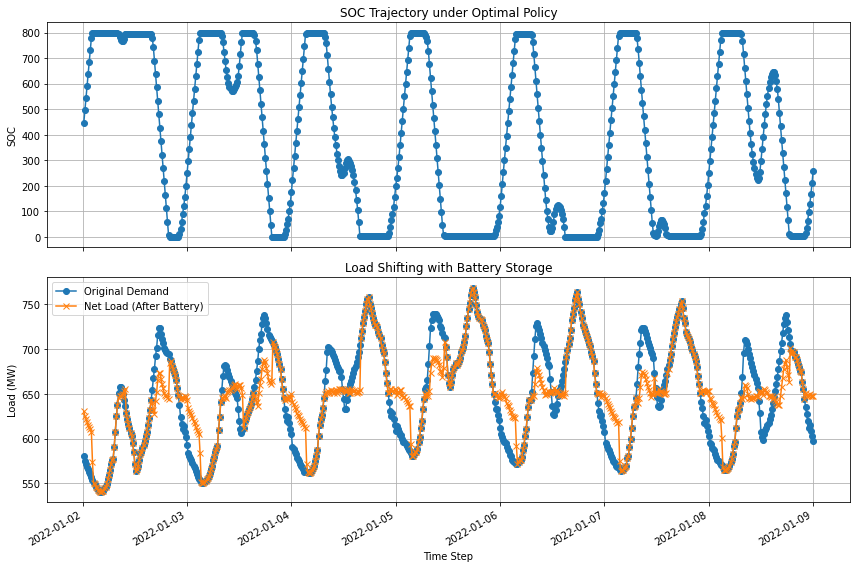

Total normalized cost (SDP): 39.66


In [28]:
time_axis = load_week["Time"].values
init_soc = 0.5 * SOC_max  # Start at 50% of battery capacity
init_soc_idx = np.argmin(np.abs(S_space - init_soc))
soc_traj = simulate_policy(policy, S_space, U_space, eff_c, eff_d, T, init_soc_idx)
net_load, soc_traj2 = simulate_net_load(policy, S_space, eff_c, eff_d, T, init_soc, demand)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First plot: SOC trajectory
axs[0].plot(time_axis, soc_traj[1:], marker='o')
axs[0].set_ylabel('SOC')
axs[0].set_title('SOC Trajectory under Optimal Policy')
axs[0].grid(True)

# Second plot: Load shifting
axs[1].plot(time_axis, demand, label="Original Demand", marker='o')
axs[1].plot(time_axis, net_load, label="Net Load (After Battery)", marker='x')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Load (MW)')
axs[1].set_title('Load Shifting with Battery Storage')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and rotate x-axis labels nicely
plt.gcf().autofmt_xdate()
plt.tight_layout()

# Save the figure
plt.savefig('Beta0.9_SOC_and_LoadShift.png')
plt.show()

# Add after your simulation
soc = init_soc
total_cost_sdp = 0.0
for t in range(T):
    a = policy[t, int(round(soc / SOC_step))]

    # Apply action and update SOC
    if a >= 0:
        actual_charge = min(a, (SOC_max - soc) / eff_c)
        soc_new = soc + eff_c * actual_charge
    else:
        actual_discharge = max(a, -soc * eff_d)
        soc_new = soc + actual_discharge / eff_d
    soc_new = np.clip(soc_new, 0, SOC_max)

    # Compute normalized cost
    pt = p[t]
    D_t = demand[t]
    norm_op = ((pt - p_bar) * a) / scale_C1
    norm_shift = ((D_t + a - D_bar) ** 2) / scale_C2
    total_cost_sdp += beta * norm_op + (1 - beta) * norm_shift

    soc = soc_new

print(f"Total normalized cost (SDP): {total_cost_sdp:.2f}")

# MPC beta = 0.9

In [29]:
p_new = load_week["DayAheadPrice"].values
p_bar = np.mean(p_new)
w = 0.9
H = 4
# Fit AR model to historical demand
model = AutoReg(demand, lags=4).fit()

# At time t, predict H-step ahead
def predict_demand_AR(current_series, H):
    if len(current_series) < 10:  # ensure enough data
        return np.full(H, np.mean(current_series))  # fallback: mean prediction
    try:
        model = AutoReg(current_series, lags=4).fit()
        forecast = model.predict(start=len(current_series), end=len(current_series) + H - 1)
        return forecast
    except Exception as e:
        print(f"AR model failed at length {len(current_series)}: {e}")
        return np.full(H, np.mean(current_series))  # fallback

In [30]:
# normalization
scale_op = np.max(np.abs((p_new - p_bar)[:, None] * U_space))
scale_shift = np.max((demand - D_bar)[:, None] + U_space) ** 2

In [31]:

def solve_mpc(t_now, soc_now, demand_hist, H=4):
    demand_pred = predict_demand_AR(demand_hist, H)
    pt = p_new[t_now:t_now + H]
    u0 = np.zeros(H)
    bounds = [(-U_max, U_max)] * H

    def cost(u):
        soc = soc_now
        total_cost = 0.0
        for k in range(H):
            a = u[k]
            # Apply realistic action limits
            if a >= 0:
                max_charge = (SOC_max - soc) / eff_c
                actual_charge = min(a, max_charge)
                soc_new = soc + eff_c * actual_charge
            else:
                max_discharge = soc * eff_d
                actual_discharge = max(a, -max_discharge)
                soc_new = soc + actual_discharge / eff_d
            soc_new = np.clip(soc_new, 0, SOC_max)

            # Compute cost
            D_k = demand_pred[k]
            norm_op_cost = ((pt[k] - p_bar) * a) / scale_op
            norm_shift_penalty = ((D_k + a - D_bar) ** 2) / scale_shift
            total_cost += w * norm_op_cost + (1 - w) * norm_shift_penalty
            #op_cost = w * (pt[k]-p_bar) * a
            #shift_penalty = (1 - w) * (D_k + a - D_bar) ** 2
            #total_cost += op_cost + shift_penalty
            soc = soc_new
        return total_cost

    result = minimize(cost, u0, bounds=bounds, method='SLSQP')
    return result.x[0]

In [32]:

# Initialize cost tracker
total_cost_mpc = 0.0

# ---------------------------
# Run MPC simulation
# ---------------------------
SOC = [400.0]  # initial SOC
actual_actions = []
start_time = 10

for t in range(start_time, T - H):
    u = solve_mpc(t, SOC[-1], demand[:t+1], H)
    soc_now = SOC[-1]

    # Realistic SOC update
    if u >= 0:
        max_charge_possible = (SOC_max - soc_now) / eff_c
        actual_charge = min(u, max_charge_possible)
        soc_next = soc_now + eff_c * actual_charge
        actual_action = actual_charge
    else:
        max_discharge_possible = soc_now * eff_d
        actual_discharge = max(u, -max_discharge_possible)
        soc_next = soc_now + actual_discharge / eff_d
        actual_action = actual_discharge

    soc_next = np.clip(soc_next, 0, SOC_max)
    SOC.append(soc_next)
    actual_actions.append(actual_action)

    # ----- Cost computation -----
    pt = p[t]
    D_t = demand[t]
    norm_op = ((pt - p_bar) * actual_action) / scale_op
    norm_shift = ((D_t + actual_action - D_bar)**2) / scale_shift
    step_cost = w * norm_op + (1 - w) * norm_shift
    total_cost_mpc += step_cost

# After the loop
print(f"Total normalized cost (MPC): {total_cost_mpc:.2f}")

Total normalized cost (MPC): -54.94


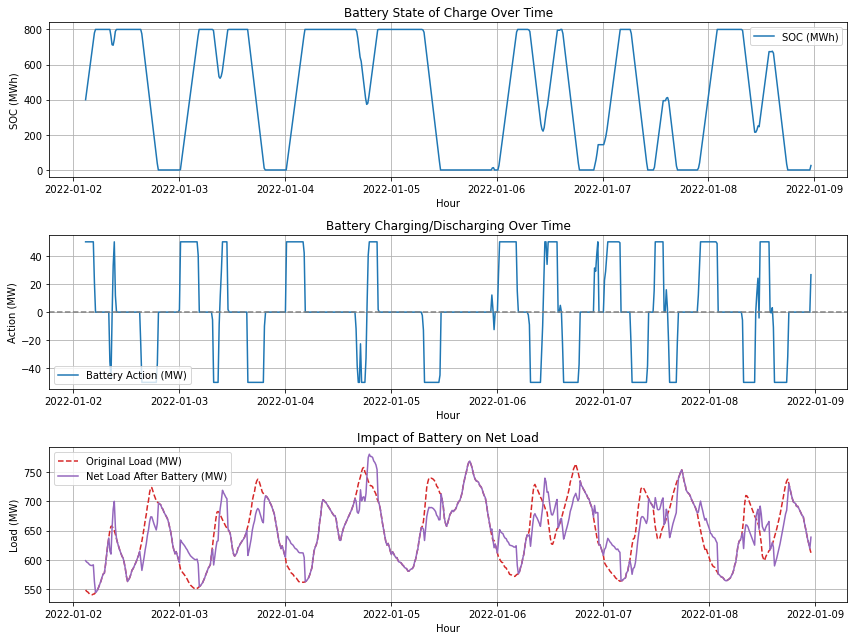

In [33]:
# ---------------------------
# Visualizations
# ---------------------------
time_SOC = np.arange(start_time, start_time + len(SOC))
time_actions = np.arange(start_time, start_time + len(actual_actions))
net_load = demand[start_time:start_time + len(actual_actions)] + actual_actions
fig, axs = plt.subplots(3, 1, figsize=(12, 9))#, sharex=True)

# 1. Battery SOC
axs[0].plot(time_axis[start_time:start_time + len(SOC)], SOC, label='SOC (MWh)')
axs[0].set_title("Battery State of Charge Over Time")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("SOC (MWh)")
axs[0].grid(True)
axs[0].legend()

# 2. Control Actions
axs[1].plot(time_axis[start_time:start_time + len(actual_actions)], actual_actions, label='Battery Action (MW)')
axs[1].axhline(0, linestyle='--', color='gray')
axs[1].set_title("Battery Charging/Discharging Over Time")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Action (MW)")
axs[1].grid(True)
axs[1].legend()


# 3. Net Load After Battery
axs[2].plot(time_axis[start_time:start_time + len(actual_actions)], demand[start_time:start_time + len(actual_actions)], '--', label="Original Load (MW)", color='tab:red')
axs[2].plot(time_axis[start_time:start_time + len(actual_actions)], net_load, label="Net Load After Battery (MW)", color='tab:purple')
axs[2].set_title("Impact of Battery on Net Load")
axs[2].set_xlabel("Hour")
axs[2].set_ylabel("Load (MW)")
axs[2].grid(True)
axs[2].legend()
fig.tight_layout()
plt.savefig('MPC0.9.png')
plt.show()

# MPC beta = 0.1

In [34]:
w = 0.1
# Initialize cost tracker
total_cost_mpc = 0.0

# ---------------------------
# Run MPC simulation
# ---------------------------
SOC = [400.0]  # initial SOC
actual_actions = []
start_time = 10

for t in range(start_time, T - H):
    u = solve_mpc(t, SOC[-1], demand[:t+1], H)
    soc_now = SOC[-1]

    # Realistic SOC update
    if u >= 0:
        max_charge_possible = (SOC_max - soc_now) / eff_c
        actual_charge = min(u, max_charge_possible)
        soc_next = soc_now + eff_c * actual_charge
        actual_action = actual_charge
    else:
        max_discharge_possible = soc_now * eff_d
        actual_discharge = max(u, -max_discharge_possible)
        soc_next = soc_now + actual_discharge / eff_d
        actual_action = actual_discharge

    soc_next = np.clip(soc_next, 0, SOC_max)
    SOC.append(soc_next)
    actual_actions.append(actual_action)

    # ----- Cost computation -----
    pt = p[t]
    D_t = demand[t]
    norm_op = ((pt - p_bar) * actual_action) / scale_op
    norm_shift = ((D_t + actual_action - D_bar)**2) / scale_shift
    step_cost = w * norm_op + (1 - w) * norm_shift
    total_cost_mpc += step_cost

# After the loop
print(f"Total normalized cost (MPC): {total_cost_mpc:.2f}")

Total normalized cost (MPC): 37.95


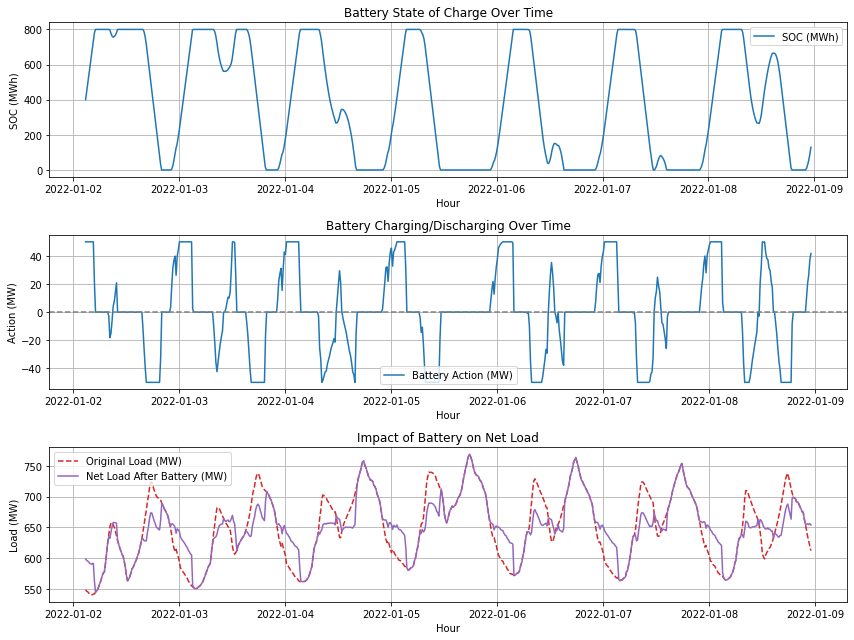

In [35]:
# ---------------------------
# Visualizations
# ---------------------------
time_SOC = np.arange(start_time, start_time + len(SOC))
time_actions = np.arange(start_time, start_time + len(actual_actions))
net_load = demand[start_time:start_time + len(actual_actions)] + actual_actions
fig, axs = plt.subplots(3, 1, figsize=(12, 9))#, sharex=True)

# 1. Battery SOC
axs[0].plot(time_axis[start_time:start_time + len(SOC)], SOC, label='SOC (MWh)')
axs[0].set_title("Battery State of Charge Over Time")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("SOC (MWh)")
axs[0].grid(True)
axs[0].legend()

# 2. Control Actions
axs[1].plot(time_axis[start_time:start_time + len(actual_actions)], actual_actions, label='Battery Action (MW)')
axs[1].axhline(0, linestyle='--', color='gray')
axs[1].set_title("Battery Charging/Discharging Over Time")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Action (MW)")
axs[1].grid(True)
axs[1].legend()


# 3. Net Load After Battery
axs[2].plot(time_axis[start_time:start_time + len(actual_actions)], demand[start_time:start_time + len(actual_actions)], '--', label="Original Load (MW)", color='tab:red')
axs[2].plot(time_axis[start_time:start_time + len(actual_actions)], net_load, label="Net Load After Battery (MW)", color='tab:purple')
axs[2].set_title("Impact of Battery on Net Load")
axs[2].set_xlabel("Hour")
axs[2].set_ylabel("Load (MW)")
axs[2].grid(True)
axs[2].legend()
fig.tight_layout()
plt.savefig('MPC0.1.png')
plt.show()